<a href="https://colab.research.google.com/github/juhungaro/Pipoca/blob/main/Satveg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etapa 1 – Pré-processamento dos Dados

*   Organizar os datasets de imagens e dados temporais coletados na Sprint 1.
*   Realizar tratamento dos dados, garantindo que estejam estruturados e prontos para serem usados no modelo.
*   Identificar padrões e sazonalidades na série temporal NDVI, explorando diferentes abordagens estatísticas para entender variações de produtividade.

# Bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from google.colab import files
import re
import altair as alt
from typing import Dict, List, Literal, Optional, Any
import requests
import pandas as pd
from datetime import datetime, timedelta
import json
import os
import glob
import warnings
from google.colab import files
from scipy import stats


# Dados SatVeg

Dados obtidos do sensor SatVeg para a Fazenda São José, Sorriso-MT
Coordenadas: -55.95520,-12.88229 | -55.95729,-12.88229

In [2]:
# 1. Carregamento importação de dados
print("1. Carregamento dos dados do SatVeg")
from google.colab import files
uploaded = files.upload()

# Carregar o arquivo CSV
filename = list(uploaded.keys())[0]
df_satveg = pd.read_csv(filename, encoding='latin1', sep=';')

# Informações básicas
print(f"Arquivo carregado: {filename}")
print(f"Dimensões: {df_satveg.shape[0]} linhas x {df_satveg.shape[1]} colunas")


1. Carregamento dos dados do SatVeg


Saving dados_satveg.csv to dados_satveg.csv
Arquivo carregado: dados_satveg.csv
Dimensões: 576 linhas x 4 colunas


In [3]:
## 2. Pré-processamento
print("\n2. Pré-processamento dos dados")

# Converter colunas data
if 'Data' in df_satveg.columns:
    df_satveg['Data'] = pd.to_datetime(df_satveg['Data'], format='%d/%m/%Y', errors='coerce')
    print("- Coluna 'Data' convertida para datetime")

# Converter colunas numéricas
colunas_numericas = ["NDVI", "PreFiltro", "FlatBottom"]
print("- Convertendo colunas numéricas:")

for coluna in colunas_numericas:
    if coluna in df_satveg.columns:
        # Guardar tipo original para mostrar a mudança
        tipo_original = df_satveg[coluna].dtype

        # Converter de string com vírgula para float
        if df_satveg[coluna].dtype == 'object':
            df_satveg[coluna] = df_satveg[coluna].str.replace(',', '.').astype(float)
            print(f"  Coluna '{coluna}' convertida: {tipo_original} → {df_satveg[coluna].dtype}")
        else:
            print(f"  Coluna '{coluna}' já é do tipo numérico: {df_satveg[coluna].dtype}")
    else:
        print(f"  Atenção: Coluna '{coluna}' não encontrada no DataFrame")

# Verificar valores nulos
nulos = df_satveg.isnull().sum()
print("- Valores nulos por coluna:")
print(nulos[nulos > 0] if any(nulos > 0) else "  Não há valores nulos")


2. Pré-processamento dos dados
- Coluna 'Data' convertida para datetime
- Convertendo colunas numéricas:
  Coluna 'NDVI' convertida: object → float64
  Coluna 'PreFiltro' convertida: object → float64
  Coluna 'FlatBottom' convertida: object → float64
- Valores nulos por coluna:
  Não há valores nulos


In [4]:
df_satveg.head()

,Data,NDVI,PreFiltro,FlatBottom
0,2000-02-18,0.6119,0.6542,0.6542
1,2000-03-05,0.6542,0.6542,0.6542
2,2000-03-21,0.5751,0.5751,0.6542
3,2000-04-06,0.6839,0.6839,0.6839
4,2000-04-22,0.4797,0.4797,0.4808


In [5]:
# Garante que 'Data' está como datetime
df_satveg['Data'] = pd.to_datetime(df_satveg['Data'], errors='coerce')

# Cria a coluna 'AnoMes' no formato 'YYYY-MM'
df_satveg['AnoMes'] = df_satveg['Data'].dt.to_period('M').astype(str)

if 'NDVI' in df_satveg.columns and 'AnoMes' in df_satveg.columns:
    # Para cada mês, calcula a média e atribui a todas as linhas daquele mês
    df_satveg['NDVI_media_mensal'] = df_satveg.groupby('AnoMes')['NDVI'].transform('mean')
    print("\nColuna 'NDVI_media_mensal' adicionada ao DataFrame!")
    print(df_satveg[['Data', 'NDVI', 'AnoMes', 'NDVI_media_mensal']].head())
else:
    print("\nNão foi possível criar a média mensal do NDVI: Colunas necessárias não encontradas.")





Coluna 'NDVI_media_mensal' adicionada ao DataFrame!
        Data    NDVI   AnoMes  NDVI_media_mensal
0 2000-02-18  0.6119  2000-02            0.61190
1 2000-03-05  0.6542  2000-03            0.61465
2 2000-03-21  0.5751  2000-03            0.61465
3 2000-04-06  0.6839  2000-04            0.58180
4 2000-04-22  0.4797  2000-04            0.58180


In [6]:
## 3. Análise Exploratória Básica
print("\n3. Análise Exploratória Básica")
print("- Primeiras linhas dos dados:")
display(df_satveg.head())

print("\n- Resumo estatístico das colunas numéricas:")
display(df_satveg[colunas_numericas].describe())


3. Análise Exploratória Básica
- Primeiras linhas dos dados:


,Data,NDVI,PreFiltro,FlatBottom,AnoMes,NDVI_media_mensal
0,2000-02-18,0.6119,0.6542,0.6542,2000-02,0.61190
1,2000-03-05,0.6542,0.6542,0.6542,2000-03,0.61465
2,2000-03-21,0.5751,0.5751,0.6542,2000-03,0.61465
3,2000-04-06,0.6839,0.6839,0.6839,2000-04,0.58180
4,2000-04-22,0.4797,0.4797,0.4808,2000-04,0.58180



- Resumo estatístico das colunas numéricas:


,NDVI,PreFiltro,FlatBottom
count,576.000000,576.000000,576.000000
mean,0.438249,0.470147,0.478435
std,0.185401,0.178731,0.176696
min,-0.300000,0.158200,0.187300
25%,0.291450,0.307225,0.310100
50%,0.391100,0.447650,0.468250
75%,0.590000,0.624850,0.629725
max,0.871500,0.871500,0.871500



4. Visualização de Dados
 Histograma - Distribuição das variáveis:


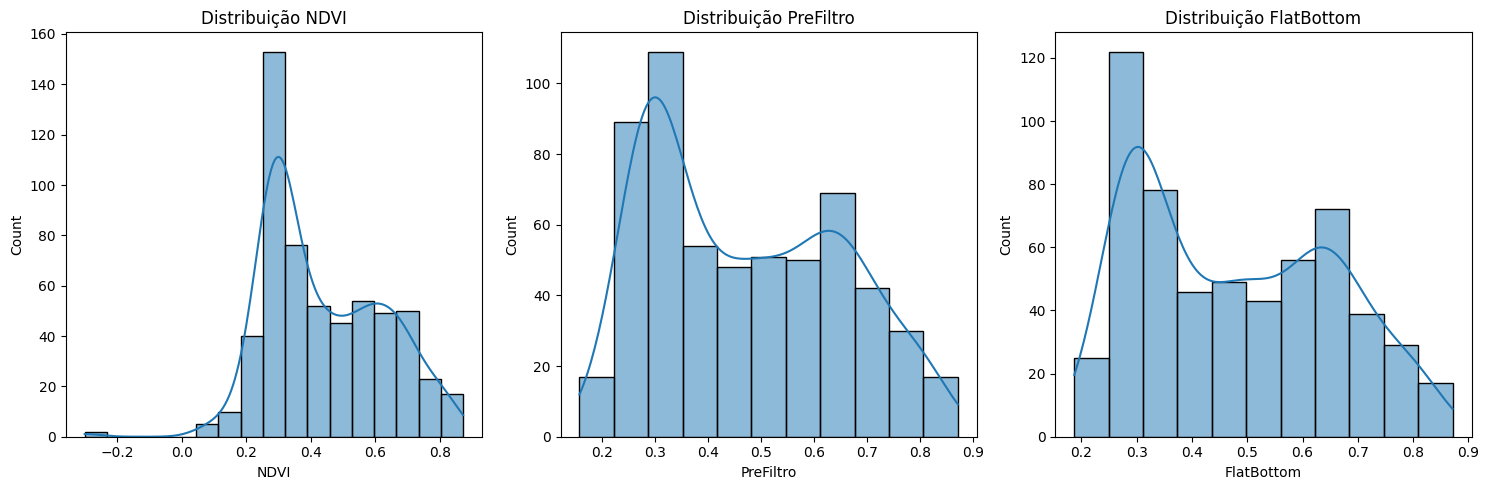

In [7]:
## 4. Visualização de Dados
print("\n4. Visualização de Dados")

# 4.1 Distribuições (histogramas)
print(" Histograma - Distribuição das variáveis:")
plt.figure(figsize=(15, 5))

for i, coluna in enumerate(colunas_numericas):
    plt.subplot(1, 3, i+1)
    sns.histplot(df_satveg[coluna], kde=True)
    plt.title(f'Distribuição {coluna}')

plt.tight_layout()
plt.show()


 Evolução temporal das métricas:


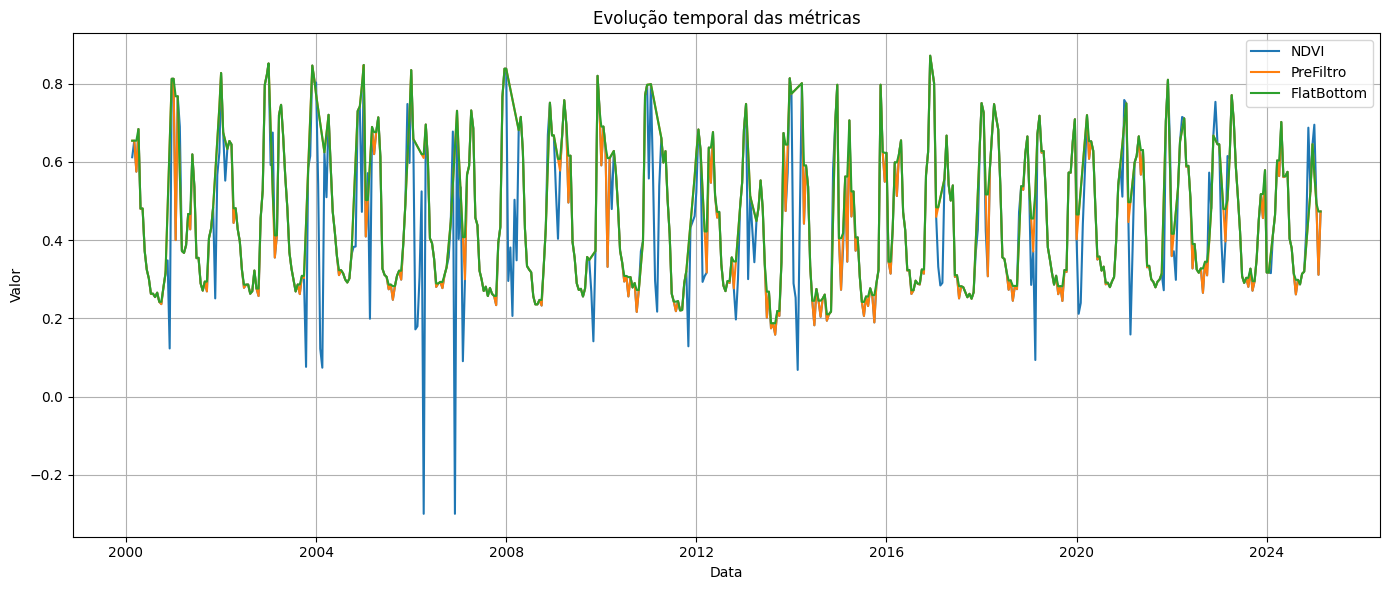

In [8]:
# 4.2 Séries temporais
print("\n Evolução temporal das métricas:")
plt.figure(figsize=(14, 6))
for coluna in colunas_numericas:
    plt.plot(df_satveg['Data'], df_satveg[coluna], label=coluna)
plt.title('Evolução temporal das métricas')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



 Dispersão - Relações entre variáveis:


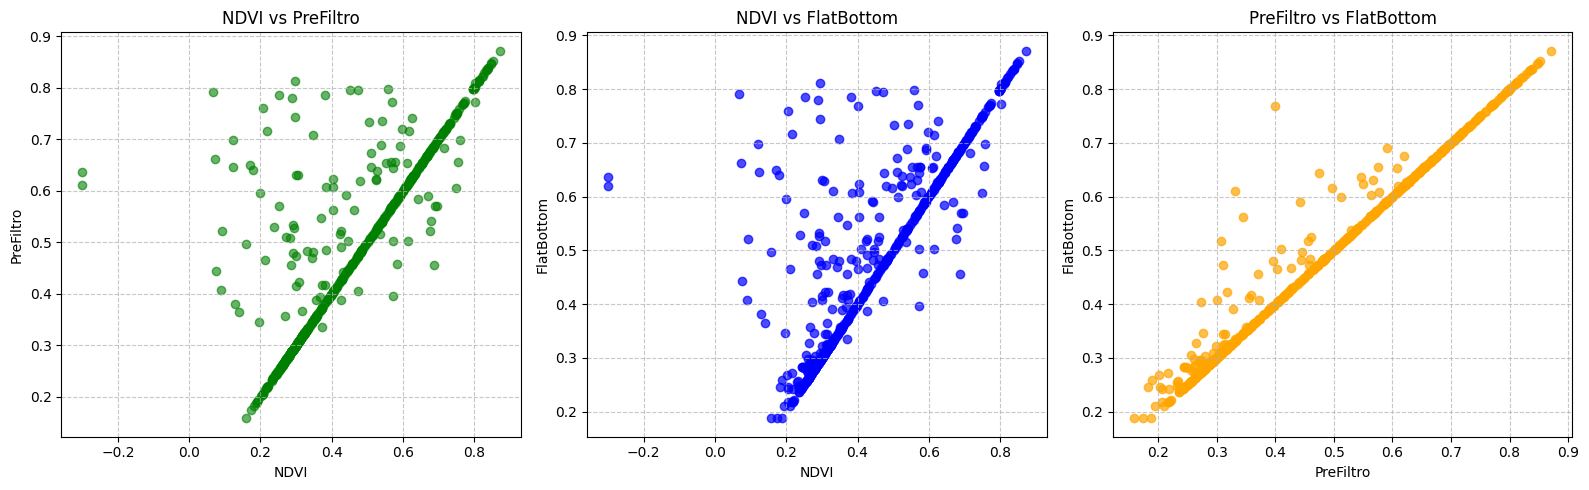

In [9]:
# 4.3 Relações entre variáveis (dispersão)
print("\n Dispersão - Relações entre variáveis:")
plt.figure(figsize=(16, 5))

# Gráfico 1: NDVI vs PreFiltro
plt.subplot(1, 3, 1)
plt.scatter(df_satveg['NDVI'], df_satveg['PreFiltro'], alpha=0.6, color='green' )
plt.title('NDVI vs PreFiltro')
plt.xlabel('NDVI')
plt.ylabel('PreFiltro')
plt.grid(True, linestyle='--', alpha=0.7)

# Gráfico 2: NDVI vs FlatBottom
plt.subplot(1, 3, 2)
plt.scatter(df_satveg['NDVI'], df_satveg['FlatBottom'], alpha=0.7, color='blue')
plt.title('NDVI vs FlatBottom')
plt.xlabel('NDVI')
plt.ylabel('FlatBottom')
plt.grid(True, linestyle='--', alpha=0.7)

# Gráfico 3: PreFiltro vs FlatBottom
plt.subplot(1, 3, 3)
plt.scatter(df_satveg['PreFiltro'], df_satveg['FlatBottom'], alpha=0.7, color='orange')
plt.title('PreFiltro vs FlatBottom')
plt.xlabel('PreFiltro')
plt.ylabel('FlatBottom')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


 Boxplots - Comparação de distribuição entre variáveis:


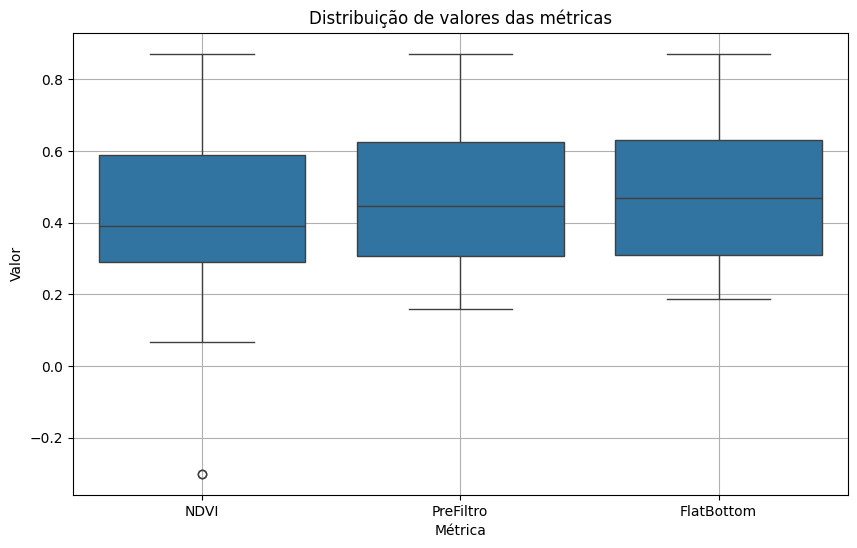

In [10]:
# 4.4 Comparação de variáveis (boxplots)
print("\n Boxplots - Comparação de distribuição entre variáveis:")
plt.figure(figsize=(10, 6))
df_melt = df_satveg.melt(id_vars='Data', value_vars=colunas_numericas,
                  var_name='Métrica', value_name='Valor')
sns.boxplot(x='Métrica', y='Valor', data=df_melt)
plt.title('Distribuição de valores das métricas')
plt.grid(True)
plt.show()


 Matriz de correlação entre as métricas:


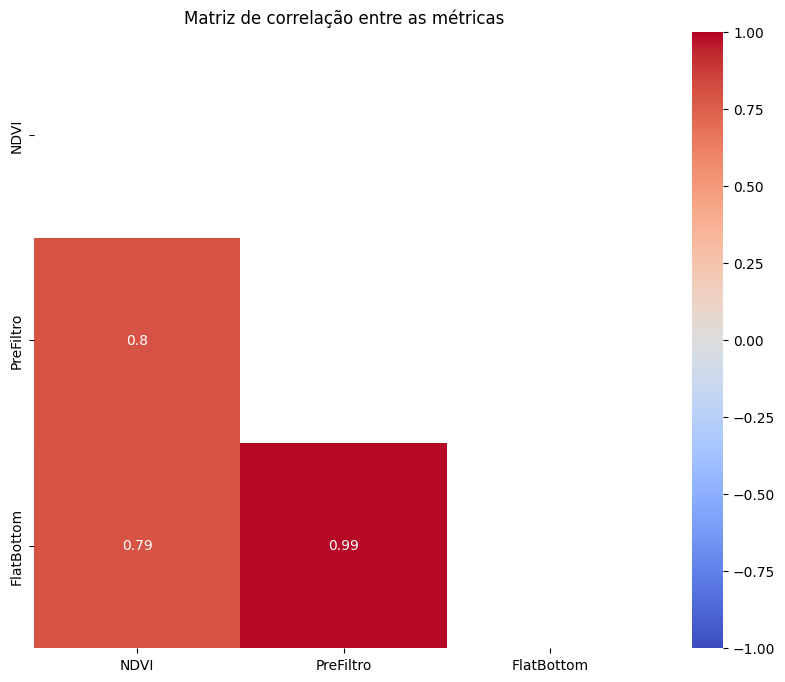

In [11]:
# 4.5 Matriz de correlação
print("\n Matriz de correlação entre as métricas:")
plt.figure(figsize=(10, 8))
corr = df_satveg[colunas_numericas].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title('Matriz de correlação entre as métricas')
plt.show()



In [12]:
# 4.6 Visualizações interativas com Altair
print("\n Visualização interativa de séries temporais:")

# Criar gráfico interativo para cada métrica
charts = []
for coluna in colunas_numericas:
    chart = alt.Chart(df_satveg).mark_line().encode(
        x='Data',
        y=alt.Y(coluna, title=coluna),
        tooltip=['Data', coluna]
    ).properties(
        title=f'Série Temporal - {coluna}',
        width=300,
        height=200
    )
    charts.append(chart)

# Exibir gráficos em grid
display(alt.vconcat(*charts))



 Visualização interativa de séries temporais:


alt.VConcatChart(...)

In [13]:
df_satveg.head()

,Data,NDVI,PreFiltro,FlatBottom,AnoMes,NDVI_media_mensal
0,2000-02-18,0.6119,0.6542,0.6542,2000-02,0.61190
1,2000-03-05,0.6542,0.6542,0.6542,2000-03,0.61465
2,2000-03-21,0.5751,0.5751,0.6542,2000-03,0.61465
3,2000-04-06,0.6839,0.6839,0.6839,2000-04,0.58180
4,2000-04-22,0.4797,0.4797,0.4808,2000-04,0.58180


In [14]:
## 5. Exportação/Salvamento dos Dados Processados
print("\n5. Exportação dos Dados Processados")
df_satveg.to_csv('satveg_processado.csv', index=False)
print("- Dados processados salvos como 'satveg_processado.csv'")


5. Exportação dos Dados Processados
- Dados processados salvos como 'satveg_processado.csv'
